In [1]:
# install onnx packages
# !pip install tf2onnx onnxruntime --user

In [7]:
# Load packages
import os, pickle
import tensorflow as tf
import numpy as np
import onnxruntime
import tf2onnx
import onnxruntime as rt
from tensorflow import keras

In [5]:
# set variables
OUTDIR = '.'
file_postfix = 'PNN_20230430wp80_ANv3'

# Load ML model

In [8]:
model = keras.models.load_model(OUTDIR+'/model_'+file_postfix)

2023-09-28 17:36:07.717127: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cvmfs/sft.cern.ch/lcg/releases/MCGenerators/thepeg/2.2.3-6fa5c/x86_64-centos7-gcc11-opt/lib/ThePEG:/cvmfs/sft.cern.ch/lcg/releases/MCGenerators/herwig++/7.2.3-c1d8e/x86_64-centos7-gcc11-opt/lib/Herwig:/cvmfs/sft.cern.ch/lcg/views/LCG_103swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/jaxlib/mlir/_mlir_libs:/cvmfs/sft.cern.ch/lcg/views/LCG_103swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/torch/lib:/cvmfs/sft.cern.ch/lcg/views/LCG_103swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/onnxruntime/capi/:/cvmfs/sft.cern.ch/lcg/views/LCG_103swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/tensorflow:/cvmfs/sft.cern.ch/lcg/views/LCG_103swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/tensorflow/contrib/tensor_fo

# Load sample data and draw

In [10]:
# 100 events for sig, bkg
sample_sigbkg = pickle.load(open('sample_sigbkg.pkl','rb'))

(array([64.,  8.,  7.,  4.,  3.,  5.,  3.,  1.,  2.,  3.]),
 array([0.0077759 , 0.08830456, 0.16883321, 0.24936186, 0.32989052,
        0.41041917, 0.4909478 , 0.57147646, 0.65200514, 0.73253375,
        0.8130624 ], dtype=float32),
 <BarContainer object of 10 artists>)

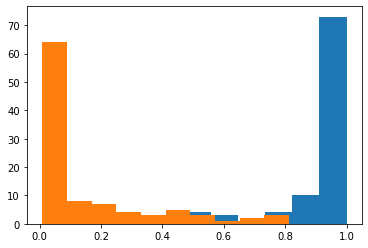

In [42]:
sig_pred = model.predict(sample_sigbkg['sig'], batch_size=sample_sigbkg['sig'].shape[0])
bkg_pred = model.predict(sample_sigbkg['bkg'], batch_size=sample_sigbkg['bkg'].shape[0])

import matplotlib.pyplot as plt
plt.hist(sig_pred)
plt.hist(bkg_pred)

# Convert TF to OONX

In [9]:
output_path = model.name + ".onnx"

# model_proto, _ = tf2onnx.convert.from_keras(model, input_signature=spec, opset=13, output_path=output_path)
model_proto, _ = tf2onnx.convert.from_keras(model, output_path=output_path)
output_names = [n.name for n in model_proto.graph.output]

2023-09-28 17:47:22.973303: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2023-09-28 17:47:22.973773: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-09-28 17:47:23.009891: I tensorflow/core/grappler/optimizers/meta_optimizer.cc:1164] Optimization results for grappler item: graph_to_optimize
  function_optimizer: Graph size after: 80 nodes (64), 129 edges (113), time = 4.018ms.
  function_optimizer: function_optimizer did nothing. time = 0.022ms.

2023-09-28 17:47:23.272792: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2023-09-28 17:47:23.272977: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-09-28 17:47:23.313815: I tensorflow/core/grappler/optimizers/meta_optimizer.cc:1164] Optimization results for grappler item: graph_to_optimize
  constant_folding: Graph size after: 56 node

# Load OONX and compare with TF

(array([64.,  8.,  7.,  4.,  3.,  5.,  3.,  1.,  2.,  3.]),
 array([0.0077759 , 0.08830456, 0.16883321, 0.24936186, 0.32989052,
        0.41041917, 0.4909478 , 0.57147646, 0.65200514, 0.73253375,
        0.8130624 ], dtype=float32),
 <BarContainer object of 10 artists>)

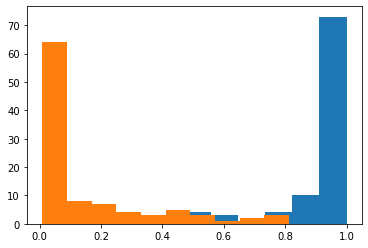

In [47]:
providers = ['CPUExecutionProvider']
m = rt.InferenceSession(output_path, providers=providers)
input_name = m.get_inputs()[0].name
output_name = m.get_outputs()[0].name

onnx_sig_pred = m.run([output_name], {input_name: np.float32(sample_sigbkg['sig'])})
onnx_bkg_pred = m.run([output_name], {input_name: np.float32(sample_sigbkg['bkg'])})

import matplotlib.pyplot as plt

plt.hist(onnx_sig_pred[0])
plt.hist(onnx_bkg_pred[0])